## <center>TP3: Practical introduction to Machine Learning Classification (MNIST dataset)<center>

## Loading the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
mnist = np.load("digits.npz")

# Training set
x2 = mnist["x"]
y2 = mnist["y"]

# Testing set
xt2 = mnist["xt"]
yt2 = mnist["yt"]

print(x2.shape)
print(xt2.shape)

(3000, 784)
(1500, 784)


In [3]:
x2, xt2 = x2/255, xt2/255

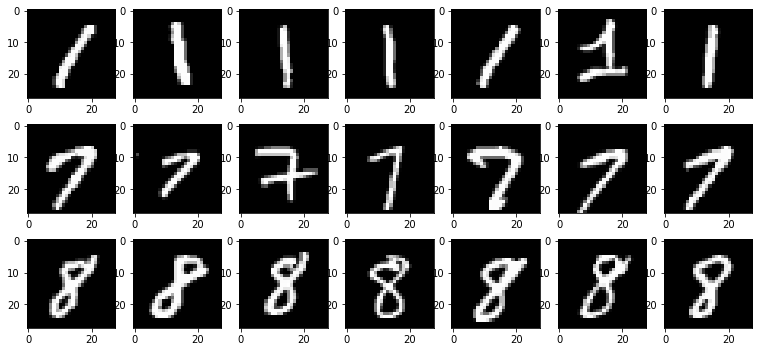

In [4]:
nrows, ncols = 3, 7
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(13, 6)) 

digits = np.unique(y2)

for i, digit in enumerate(digits):
    for j in range(ncols):
        ax[i,j].imshow(x2[1000*i+j,:].reshape(28,28), "gray")

plt.show()

This dataset is composed of images of shape (28x28). On each image, there is either a 1 digit, a 7 or a 8: this is a $K=3$ multiclass problem.



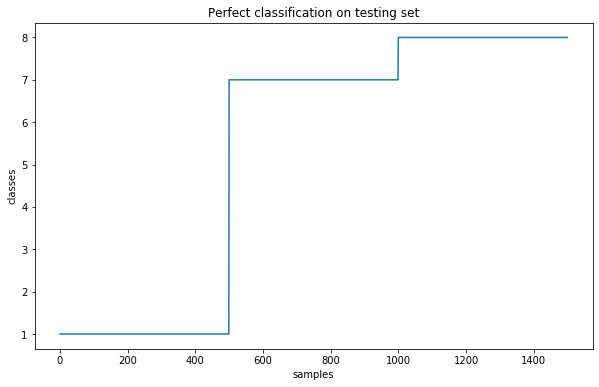

In [47]:
# Perfect classification 

fig = plt.figure(figsize=(10,6))
plt.plot(range(len(yt2)), yt2)
plt.xlabel("samples")
plt.ylabel("classes")
plt.title("Perfect classification on testing set")
plt.show()

Because the digits are sorted in the testing set (the first 500 images belong to class 1, the next 500 images to class 7 and the last 500 images to class 8), good predictions should provide a constant piecewise plot like the one above.

## Predicting classes on the digits dataset

### 3.1 Evaluate the different supervised methods

### Linear Discriminant Analysis

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
warnings.filterwarnings("ignore")

lda = LinearDiscriminantAnalysis()
lda.fit(x2, y2)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [7]:
def plot_predictions(model, x_test=xt2, y_test=yt2, model_name=""):
    #from sklearn.metrics import confusion_matrix
    
    preds = model.predict(x_test)
    acc = model.score(x_test, y_test)
    print("Accuracy of {}: {:.4f}".format(model_name, acc))
    
    fig = plt.figure(figsize=(7,5))
    
    plt.plot(range(len(y_test)), preds, marker="|")
    plt.xlabel("samples")
    plt.ylabel("classes")
    plt.title("Predictions of {} on testing set".format(model_name))
    plt.show()
    return acc

Accuracy of default LDA: 0.9333


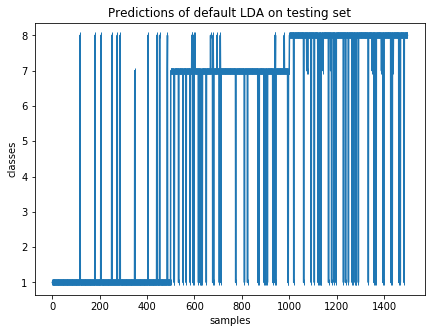

In [634]:
acc_lda = plot_predictions(model=lda, model_name="default LDA")

The plot on the right strikingly reveals that LDA's predictions are far from being perfect: unless we can perceive 3 constant phases from 0 to 500, from 500 to 1000 and 1000 to 1500, there are many undesired vertical bars, which were not present in the "perfect classification on testing set" plot previously introduced.

A large majority of the vertical bars from samples 500 to 1500 (cf x axis) go down to the level 1 (cf y axis). In other words, the model predicts 1 too often. 
From samples 0 to 500, most of the vertical bars go up to the level 8, so that when the model incorrectly classify a 1, it confuses it with a 8.

**The accuracy is the proportion of correct classifications among the total number of predictions.**

Here, it equals 0.9360, so that the default LDA has more than $93\%$ of correct answers on testing set. At first sight, this is quite a good performance, but:

- we can probably do better with other models


- this dataset is very basic (it is used for introducing Machine Learning courses) so we expected a high accuracy in any case


- the accuracy doesn't inform what are the mistakes made by the model (this is why we will invest other metrics later in the notebook)

In [89]:
results_df = pd.DataFrame(data={"accuracy":[acc_lda]},
                          index=["default LDA"])
results_df

accuracy
default LDA     0.936

#### Grid Search for LDA

In [13]:
from sklearn.model_selection import GridSearchCV

params_lda = {"shrinkage": np.linspace(0,1,100)}

grid_lda = GridSearchCV(LinearDiscriminantAnalysis(solver="lsqr"), params_lda, cv=5, scoring="accuracy")
grid_lda.fit(x2, y2)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='lsqr',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='deprecated', n_jobs=None,
             param_grid={'shrinkage': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0....
       0.75757576, 0.76767677, 0.77777778, 0.78787879, 0.7979798 ,
       0.80808081, 0.81818182, 0.82828283, 0.83838384, 0.84848485,
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ])},
             pre_dispat

In [60]:
grid_lda.best_params_

{'shrinkage': 0.787878787878788}

Let's look at the predictions's plot:

Accuracy of Best LDA found by GSCV: 0.9407


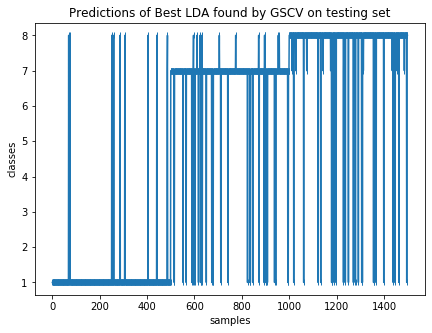

In [573]:
acc_lda_grid_bis = plot_predictions(model=grid_lda.best_estimator_, model_name="Best LDA found by GSCV")


The accuracy is slightly better than the default LDA's.

Altought the predictions plot seems to contain way less vertical bars (ie wrong predictions) from 0 to 500, this is an "illusion" because the vertical bars are grouped now. By the way, the fact that these vertical bars have different locations than previously reveals that the model misclassifies different 1 digit images now.

The improvement from the grid search is negligible.

In [90]:
results_df.loc["LDA with shrinkage=0.78",] = [acc_lda_grid]

results_df

accuracy
default LDA              0.936000
LDA with shrinkage=0.78  0.940667

### Logistic Regression

In [95]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state=0)
logit.fit(x2,y2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy of default Logistic Regression: 0.9660


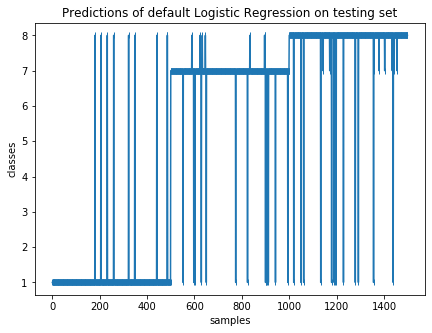

In [574]:
acc_logit = plot_predictions(model=logit, model_name="default Logistic Regression")

According to the accuracy value, the Logistic Regression does a better job than LDA on testing set ($+2.6\%$ compared to the best LDA found by grid search).

Its better performance results in a proper predictions plot, with fewer vertical bars. Notice that there are slightly fewer vertical bars from samples 0 to 500 than in the rest of the plot, meaning that the Logistic Regression is better at distinguishing 1 digit examples from the other images. But the main problem remains the same: a majority of the vertical bars from samples 500 to 1500 (cf x axis) go down to the level 1 (cf y axis). In other words, the model predicts 1 too often. 

In [97]:
results_df.loc["Default Logistic Regression",] = [acc_logit]

results_df

accuracy
default LDA                  0.936000
LDA with shrinkage=0.78      0.940667
Default Logistic Regression  0.966000

#### Grid Search for Logistic Regression

In [98]:
params_logit = {"C":np.linspace(0.1,1,10), "solver":["liblinear", "saga"]}

grid_logit = GridSearchCV(LogisticRegression(penalty="l1", random_state=0), params_logit, cv=5, scoring="accuracy")
grid_logit.fit(x2, y2)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l1',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'solver': ['liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [99]:
grid_logit.best_params_

{'C': 0.2, 'solver': 'saga'}

Accuracy of Best Logistic Regression found by GSCV: 0.9680


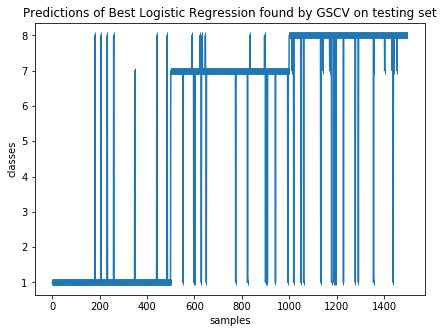

In [575]:
acc_logit_grid = plot_predictions(model=grid_logit.best_estimator_, model_name="Best Logistic Regression found by GSCV")


As for the LDA, the grid search lead to a negligible drastic boost of the performances for Logistic Regression. The accuracy is almost the same ($0.9660$ vs $0.9680$), as well as the predictions plot: the vertical bars/incorrect classifications are as numberous as before, and are even located at the same places, that is to say the model failed on the same images as previously.

In [102]:
results_df.loc["Logistic Regression with C=0.2, solver=saga, penalty=l1",] = [acc_logit_grid]

results_df

accuracy
default LDA                                         0.936000
LDA with shrinkage=0.78                             0.940667
Default Logistic Regression                         0.966000
Logistic Regression with C=0.2, solver=saga, pe...  0.968000

### SVC

In [5]:
from sklearn.svm import SVC

svc = SVC(random_state=0, probability=True)
svc.fit(x2,y2)

/Users/terencengo/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

Accuracy of Default SVC: 0.9833


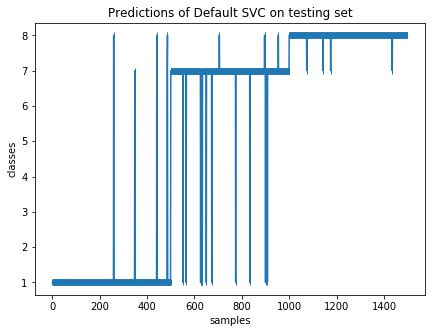

In [8]:
acc_svc = plot_predictions(model=svc, model_name="Default SVC")

The accuracy reached by the SVC on testing set is the highest so far, and is confirmed by the predictions plot which has way less vertical bars than the previous ones.

Notice that:

- there are more vertical bars from samples 500 to 1000: the SVC has more difficulty classifying correctly the 7 digit images. Most of the time, it confuses the 7's with 1's since the vertical bars go from the level 7 to the level 1. 


- the vertical bars from samples 1000 to 1500 no longer go down to the level 1, but to the level 7 only: the model may confuse 8 digit images with 7, but no longer with 1.

In [103]:
results_df.loc["Default SVC",] = [acc_svc]

results_df

accuracy
default LDA                                         0.936000
LDA with shrinkage=0.78                             0.940667
Default Logistic Regression                         0.966000
Logistic Regression with C=0.2, solver=saga, pe...  0.968000
Default SVC                                         0.983333

#### Grid Search for SVC

In [547]:
params_svc = {"kernel": ["rbf","linear", "poly"],
             "C": [10**i for i in range(-2,3)]}

grid_svc = GridSearchCV(SVC(random_state=0, probability=True), params_svc, cv=5, scoring="accuracy")
grid_svc.fit(x2, y2)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=0, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'kernel': ['rbf', 'linear', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [548]:
grid_svc.best_params_

{'C': 10, 'kernel': 'rbf'}

Accuracy of Best SVC found by GSCV: 0.9833


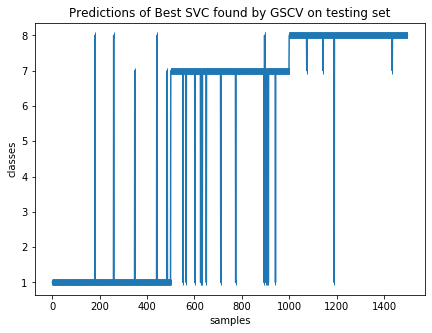

In [577]:
acc_svc_grid = plot_predictions(model=grid_svc.best_estimator_, model_name="Best SVC found by GSCV")

The grid search led to the same accuracy as the default SVC, so it has the same number of good predictions as before.
However, the mistakes (on testing set) are different now according to the position of the vertical bars on the predictions plot. A notable difference (cf from samples 1000 to 1500) is that the new parameters configuration led to confusions of 8 digit examples with 1.

### MLPClassifier

In [94]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=0)
mlp.fit(x2,y2)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Accuracy of Default MLP: 0.9767


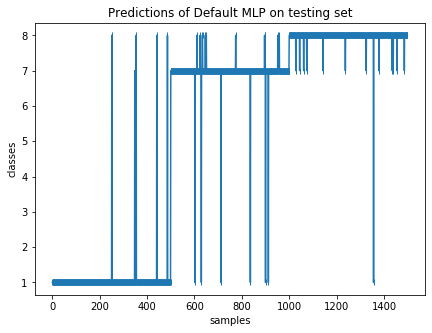

In [578]:
acc_mlp = plot_predictions(model=mlp, model_name="Default MLP")

In [113]:
results_df.loc["Default MLP",] = [acc_mlp]

results_df

accuracy
default LDA                                         0.936000
LDA with shrinkage=0.78                             0.940667
Default Logistic Regression                         0.966000
Logistic Regression with C=0.2, solver=saga, pe...  0.968000
Default SVC                                         0.983333
Default MLP                                         0.976667

#### Tuning the hyperparameters of MLP

Since a neural network contains too many hyperparameters, a grid search won't finish in a reasonable delay. Then, let's tune them manually:

In [195]:
mlp_bis = MLPClassifier(hidden_layer_sizes=(150,100),
              learning_rate_init=0.0007, learning_rate="adaptive",
             alpha=0.003, random_state=0, activation="relu")

mlp_bis.fit(x2,y2)

MLPClassifier(activation='relu', alpha=0.003, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(150, 100), learning_rate='adaptive',
              learning_rate_init=0.0007, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Accuracy of Best MLP tuned manually: 0.9800


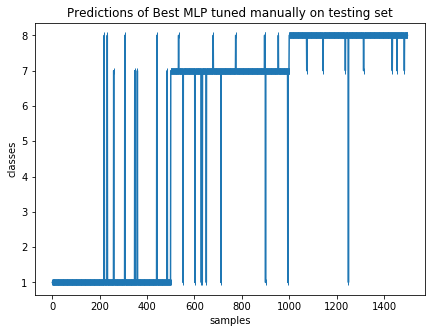

In [586]:
acc_mlp_bis = plot_predictions(model=mlp_bis, model_name="Best MLP tuned manually")

The parameters tuning led to fewer mistakes on 8 digit examples and (generally) misclassifications on different samples than before, but the proportion of mistakes almost didn't change ($97.67\%$ vs $98\%$ of correct predictions) at the end.

In [197]:
results_df.loc["MLP with hidden layers=(150,100), lr_init=0.0007, alpha=0.003, lr=adaptive",] = [acc_mlp_bis]

results_df

accuracy
default LDA                                         0.936000
LDA with shrinkage=0.78                             0.940667
Default Logistic Regression                         0.966000
Logistic Regression with C=0.2, solver=saga, pe...  0.968000
Default SVC                                         0.983333
Default MLP                                         0.976667
MLP with hidden layers=(150,100), lr_init=0.000...  0.980000

Now that all the models have been built and tested, let's sort them with respect to their accuracy to determine which ones are the best (given the accuracy metric):

In [236]:
results_df.sort_values("accuracy", ascending=False)

accuracy
Default SVC                                         0.983333
MLP with hidden layers=(150,100), lr_init=0.000...  0.980000
Default MLP                                         0.976667
Logistic Regression with C=0.2, solver=saga, pe...  0.968000
Default Logistic Regression                         0.966000
LDA with shrinkage=0.78                             0.940667
default LDA                                         0.936000

According to the accuracy metric, the default SVC is the best method for this problem.

## 3.2 Interpreting the classifier

### Recall and precision

As noticed at the beginning of the notebook, the accuracy is way too incomplete to measure the performances of the models. To have further understanding of their predictions, we have empirically looked at predictions plot so far. A more common way to analyze the compromises the models do between the classes is to compute the precisions and recalls associated to each class (for multiclass problem), then compare them:

- $\text{Recall of class k} = \frac{\text{number of correct predicted samples in the class k}}{\text{number of samples predicted as belonging to class k}} = \frac{\text{TP}_k}{\text{TP}_k + \text{FN}_k}$

where $\text{TP}_k$ is the number of true positives for class k (images predicted as belonging to class k that indeed belong to the class k) and $\text{FN}_k$ the number of false negatives for the class k (images predicted as belonging to another class while belonging to the class k).

A high recall means that when the model classify a sample in the class k, it rarely makes mistakes. But maybe the model don't classify as many samples as it should (in the class k), so that we also need to look at the precision:

- $\text{Precision of class k} = \frac{\text{number of correct predicted samples in the class k}}{\text{number of samples to find in the class k}} = \frac{\text{TP}_k}{\text{TP}_k + \text{FP}_k}$

where $\text{FP}_k$ is the number of false positive for the class k (images predicted as belonging to class k while it is in fact not the case).

A high precision means the model considers many samples from the class k as belonging in this class. But conversely, it might make mistakes on the other classes, this is why we need to look at the recall.

In [591]:
def get_precisions_recalls(model, x_test=xt2, y_test=yt2, model_name="", display=True):
    from sklearn.metrics import confusion_matrix
    
    preds = model.predict(x_test)
    acc = model.score(x_test, y_test)
    
    conf_mat = confusion_matrix(y_test, preds)
    p1 = conf_mat[0,0]/(conf_mat[0,0] + conf_mat[0,1] + conf_mat[0,2])
    r1 = conf_mat[0,0]/(conf_mat[0,0] + conf_mat[1,0] + conf_mat[2,0])
    
    p7 = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1] + conf_mat[1,2])
    r7 = conf_mat[1,1]/(conf_mat[0,1] + conf_mat[1,1] + conf_mat[2,1])
    
    p8 = conf_mat[2,2]/(conf_mat[2,0] + conf_mat[2,1] + conf_mat[2,2])
    r8 = conf_mat[2,2]/(conf_mat[0,2] + conf_mat[1,2] + conf_mat[2,2])
    
    if display:
        #print("Accuracy of {}: {:.4f} \n".format(model_name, acc))
        print("Class 1 precision of {}: {:.3f}".format(model_name,p1))
        print("Class 1 recall of {}: {:.3f}".format(model_name,r1))
        print("*"*50)
        print("Class 7 precision of {}: {:.3f}".format(model_name,p7))
        print("Class 7 recall of {}: {:.3f}".format(model_name,r7))
        print("*"*50)
        print("Class 8 precision of {}: {:.3f}".format(model_name,p8))
        print("Class 8 recall of {}: {:.3f}".format(model_name,r8))

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,8),)

        ax[0].bar(["precision class 1", "recall class 1"],[p1,r1], width=0.3, color="green", alpha=0.7)
        ax[1].bar(["precision class 7", "recall class 7"],[p7,r7], width=0.3, color="green", alpha=0.7)
        ax[2].bar(["precision class 8", "recall class 8"],[p8,r8], width=0.3, color="green", alpha=0.7)

        ax[0].set_title("Metrics on class 1")
        ax[1].set_title("Metrics on class 7")
        ax[2].set_title("Metrics on class 8")

        ax[0].grid()
        ax[1].grid()
        ax[2].grid()
        plt.show()
    
    return acc,p1,r1,p7,r7,p8,r8

In [592]:
acc_mlp, p1_mlp, r1_mlp, p7_mlp, r7_mlp, p8_mlp, r8_mlp = get_precisions_recalls(model=mlp_bis, model_name="MLP (bis)", display=False)

acc_svc, p1_svc, r1_svc, p7_svc, r7_svc, p8_svc, r8_svc = get_precisions_recalls(model=svc, model_name="SVC", display=False)

acc_logit, p1_logit, r1_logit, p7_logit, r7_logit, p8_logit, r8_logit = get_precisions_recalls(model=grid_logit.best_estimator_, model_name="Logistic Regression", display=False)

acc_lda, p1_lda, r1_lda, p7_lda, r7_lda, p8_lda, r8_lda = get_precisions_recalls(model=grid_lda.best_estimator_, model_name="LDA", display=False)


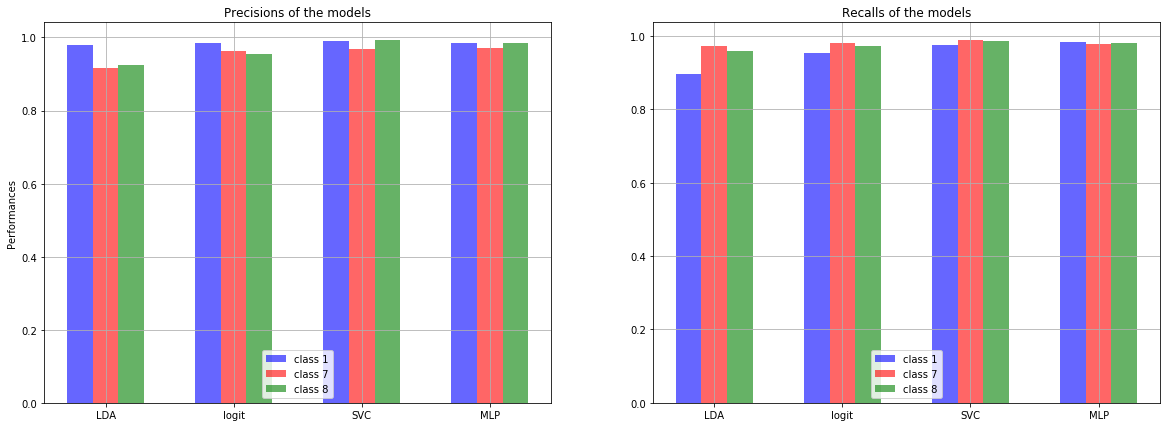

In [593]:
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

labels = ["LDA","logit","SVC","MLP"]
precisions1 = [p1_lda, p1_logit, p1_svc, p1_mlp]
precisions7 = [p7_lda, p7_logit, p7_svc, p7_mlp]
precisions8 = [p8_lda, p8_logit, p8_svc, p8_mlp]

recalls1 = [r1_lda, r1_logit, r1_svc, r1_mlp]
recalls7 = [r7_lda, r7_logit, r7_svc, r7_mlp]
recalls8 = [r8_lda, r8_logit, r8_svc, r8_mlp]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7), sharex=True)

# --------------------- Precisions ---------------------
rects1 = ax[0].bar(x - width, precisions1, width, label='class 1', alpha=0.6, color="blue")
rects2 = ax[0].bar(x, precisions7, width, label='class 7', alpha=0.6, color="red")
rects3 = ax[0].bar(x + width, precisions8, width, label='class 8', alpha=0.6, color="green")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('Performances')
ax[0].set_title('Precisions of the models')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

# --------------------- Recalls ---------------------

rects1 = ax[1].bar(x - width, recalls1, width, label='class 1', alpha=0.6, color="blue")
rects2 = ax[1].bar(x, recalls7, width, label='class 7', alpha=0.6, color="red")
rects3 = ax[1].bar(x + width, recalls8, width, label='class 8', alpha=0.6, color="green")

ax[1].set_title('Recalls of the models')
ax[1].set_xticks(x)
ax[1].legend()

ax[0].grid()
ax[1].grid()

plt.show()


Once again, SVC seems to be the best for a majority of metrics. LDA has the worst precisions and recalls, and the Logistic Regression (logit) performances are slightly under those of SVC and MLP.

Notice that for almost all the models, the precision for class 1 is higher than the precisions for the other classes, meaning that they perform pretty well on 1 digit samples (the prediction is generally 1 when the target class is indeed 1).
But they might eventually tend to output 1 even when having to predict 7 or 8, and the lower recalls for class 1 (compared to the recalls for other classes) quantifies this kind of mistake.

### AUC

We could also look at the AUC of the different models. AUC stands for $\textit{area under curve}$ and involves TP and FP, respectively the number of true positive and false positive samples for a binary classification problem. 

But because AUC metric has originally been built for binary classification problem, then we should consider our $K=3$ multiclass classification task as a collection of several binary classification tasks. There are 2 approaches:

- $\underline{\textbf{One versus One (OvO)}}$: the models are interpreted as being binary classifiers separating class 1 and class 2 samples, then binary classifiers separating class 1 and class 3 samples... until each pair of classes are reviewed. Therefore, $K(K-1)/2$ AUC are computed.


- $\underline{\textbf{One versus Rest (OvR)}}$: the models are interpreted as being binary classifiers separating class 1 samples from the rest of the dataset, then binary classifiers separating class 2 samples from the rest of the dataset... until each class has been reviewed. Therefore, $K$ AUC are computed.

In both approaches, we can end up by computing the mean of the series of AUC. We could then rely on its value (the higher the better) to choose the best model to use. 

For $K=3$ classes, both approaches lead to the computation of 3 AUCs, so it is equally complex to interpret their results. But since the OvO approach contains more information (we do not only know at which point the models can capture the essence of a class, but also with which other class there is likely to have confusion), let's use this strategy.

The computation of $\text{AUC}_k$ (the AUC for the class k) then involves $\text{TP}_k$ and $\text{FP}_k$, respectively the number of true positives for class k and false positives for class k. It does not use $\text{FN}_k$ the number of false negatives for class k as the recall did, so that the recall contains additionnal information. But since the dataset is not imbalanced, it may then be enough to consider the false positives.
Hence, in this context, AUC and precision/recall metrics should lead to the same conclusions about which models are the best ones.

For the sake of example, let's vizualise the roc auc curves of LDA and its AUC for each digit class (as well as the mean of the AUCs):

In [10]:
def get_aucs(model, y_test=yt2, model_name="", display=False):
    from sklearn.metrics import roc_auc_score, roc_curve
    
    # one-hot-encoding of yt2
    yt2_encoded = np.zeros((1500,3))

    from_class_to_ind = {1:0, 7:1, 8:2}
    from_ind_to_class = {0:1, 1:7, 2:8}

    for i in range(1500):
        j = from_class_to_ind[y_test[i][0]]
        yt2_encoded[i][j] = 1
    
    preds = model.predict_proba(xt2)
    auc1, auc2, auc3 = roc_auc_score(yt2_encoded, preds, multi_class='ovo', average=None)
    auc_mean = roc_auc_score(yt2_encoded, preds, multi_class='ovo', average="macro")
    
    if display:
        
        print("AUC metrics of {}:".format(model_name))
        print("1 vs 7 : {:.4f}".format(auc1))
        print("1 vs 8 : {:.4f}".format(auc2))
        print("7 vs 8 : {:.4f}".format(auc3))
        print("Mean AUC : {:.4f}".format(auc_mean))

        fpr = {}
        tpr = {}
        thresh ={}
        
        for i in range(3):    
            fpr[i], tpr[i], thresh[i] = roc_curve(yt2, preds[:,i], pos_label=from_ind_to_class[i])
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
        xlabels = ["1 vs 7", "1 vs 8", "7 vs 8"]
        
        ax[0].plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 1 vs Class 7')
        ax[0].plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Class 8')
        ax[0].plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 7 vs Class 8')
        ax[0].set_title('Multiclass ROC curve')
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_ylabel('True Positive rate')
        ax[0].legend(loc='best')
        
        ax[1].bar(xlabels, [auc1, auc2, auc3], width=0.3, color="red", alpha=0.8)
        ax[1].grid(True)
        plt.show()
        
    return auc1, auc2, auc3, auc_mean

AUC metrics of LDA:
1 vs 7 : 0.9833
1 vs 8 : 0.9787
7 vs 8 : 0.9830
Mean AUC : 0.9817


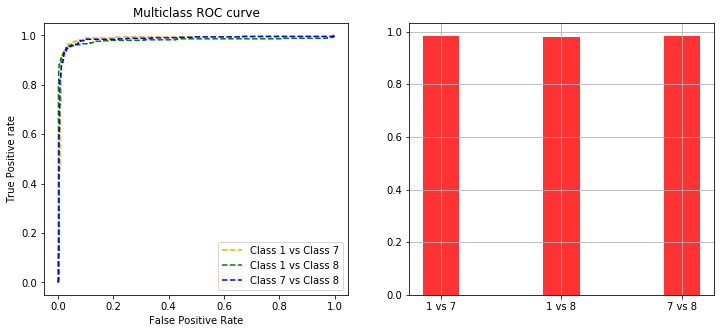

(0.9833179999999999, 0.9786699999999999, 0.98297, 0.9816526666666666)

In [12]:
get_aucs(lda, y_test=yt2, model_name="LDA", display=True)

The default LDA is better at separating the 7 digits from the 8's since the "7 vs 8" AUC is the highest among the three AUC.

The best LDA found by the grid search is better since all the AUCs are higher:

AUC metrics of LDA grid:
1 vs 7 : 0.9954
1 vs 8 : 0.9933
7 vs 8 : 0.9952
Mean AUC : 0.9946


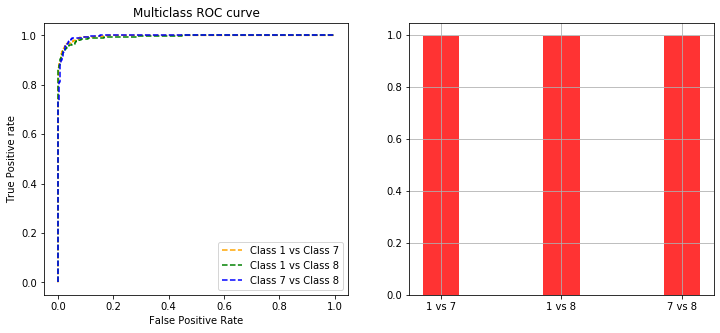

In [14]:
auc17_lda, auc18_lda, auc78_lda, auc_mean_lda = get_aucs(grid_lda.best_estimator_, y_test=yt2, model_name="LDA grid", display=True)


Now let's compute the AUC of all the models:

In [564]:
auc17_mlp, auc18_mlp, auc78_mlp, auc_mean_mlp = get_aucs(mlp_bis, y_test=yt2)

auc17_svc, auc18_svc, auc78_svc, auc_mean_svc = get_aucs(svc, y_test=yt2)

auc17_logit, auc18_logit, auc78_logit, auc_mean_logit = get_aucs(grid_logit.best_estimator_, y_test=yt2)


In [588]:
labels = ["LDA","logit","SVC","MLP"]
auc_mean_models = [auc_mean_lda, auc_mean_logit, auc_mean_svc,auc_mean_mlp]

indexes = np.flip(np.argsort([auc_mean_lda, auc_mean_logit, auc_mean_svc, auc_mean_mlp]))

print("Sorted models from best (1) to worst (4) according to mean AUC metric:\n")

for n,i in enumerate(indexes):
    print("{}) {} (mean auc = {:.4f})".format(n+1,labels[i], auc_mean_models[i]))

Sorted models from best (1) to worst (4) according to mean AUC metric:

1) SVC (mean auc = 0.9994)
2) logit (mean auc = 0.9964)
3) MLP (mean auc = 0.9950)
4) LDA (mean auc = 0.9946)


The above results are really close (and really satisfying), but **in conclusion, all the metrics we have reviewed lead to the conclusion that SVC is the best model to apply in our case.**

Next, let's analyze SVC's predictions more carefully:

### Misclassifications of images by SVC

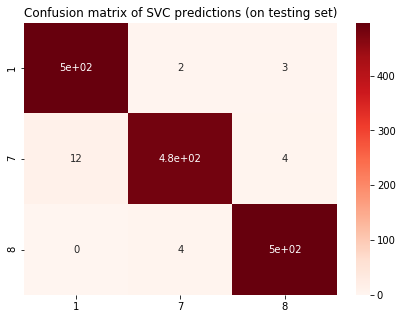

In [9]:
from sklearn.metrics import confusion_matrix

preds_svc = svc.predict(xt2)

conf_mat = confusion_matrix(yt2, preds_svc)
fig = plt.figure(figsize=(7,5))
sns.heatmap(conf_mat, annot=True,
                 xticklabels=["1","7","8"], yticklabels=["1","7","8"], cmap="Reds")
plt.title("Confusion matrix of SVC predictions (on testing set)")
plt.show()


The model's performance seems pretty correct according to the confusion matrix since the diagonal coefficients are way larger than other coefficients.

**The columns of the confusion matrix correspond to the predicted labels whereas the lines correspond to the true labels.** 

Therefore, we can notice that **the model quite often confuses 7 digits with 1**: 12 images belonging to the class 7 have been classified as belonging to the class 1. This is because a "7" written quickly can look like a "1": at the beginning of the notebooks, some of the few 7 digits shown don't have the horizontal bar which is essentially what distinguish "7" from "1".

Another mistake is that the model sometimes confuses 7 with 8, and 8 with 7 digits (4 mistakes of each type). These errors occur less often and are probably due to outliers.

**In conclusion, the hardest class to determine is the 7.**

Let's have a look at the misclassified samples:

In [683]:
preds_svc = svc.predict(xt2)

indexes_mistakes = []

for i in range(len(preds_svc)):
    if preds_svc[i] != yt2[i]:
        indexes_mistakes.append(i)

print(len(indexes_mistakes))
print(indexes_mistakes)

25
[259, 348, 441, 485, 486, 552, 565, 626, 629, 631, 633, 650, 673, 705, 774, 834, 896, 898, 900, 908, 954, 1074, 1143, 1175, 1435]


Images misclassified by SVC:



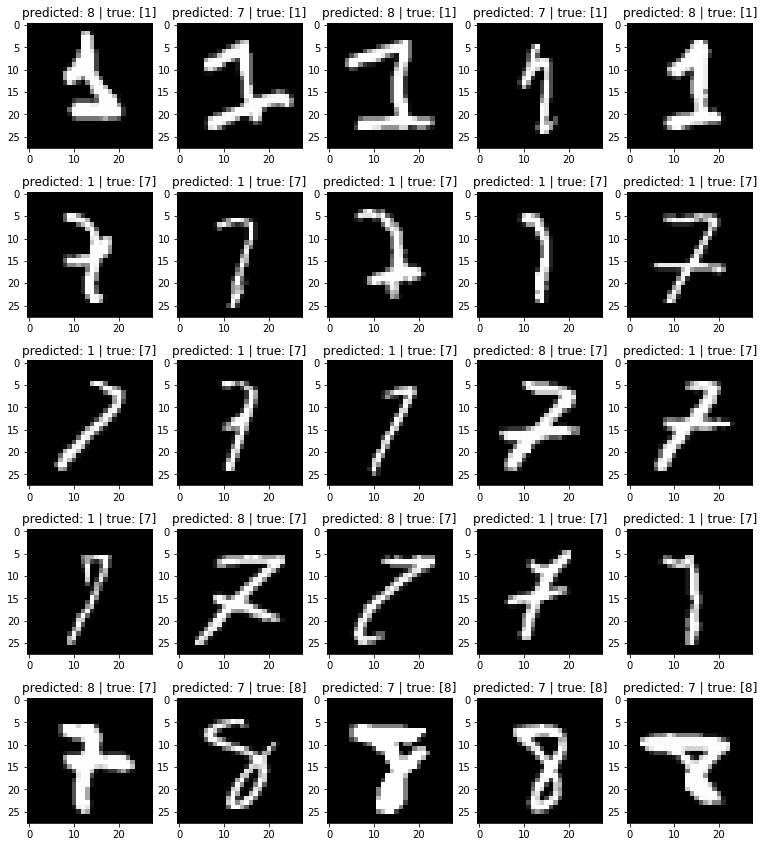

In [595]:
fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(13, 15)) 

print("Images misclassified by SVC:\n")

for i in range(5):
    for j in range(5):
        ind = indexes_mistakes[i*5+j]
        ax[i,j].imshow(xt2[ind,:].reshape(28,28), "gray")
        ax[i,j].set_title("predicted: {} | true: {}".format(preds_svc[ind], yt2[ind]))

plt.show()


- As intuited, the misclassifications of the "7" seems to come from a anomaly of the horizontal bar: six "7" among the twelve that have been confused with "1" don't have this characteristic horizontal bar. For some of them, it might be located too low (cf second image of the first line), too short (cf first image of the second line), and so on.


- There are harder images to classify in the dataset due to thicker written lines (cf the first image of the first line, as well as the digits of the last line), this is why the model failed at classifying these ones.


- Sometimes, the model has no reason to misclassify a sample, for instance the last digit of the second line; I simply can't find an explanation for such a mistake.

Next we will try to foil the model by creating noisy images from samples it initially correctly classified.

### Adversarial examples

In [18]:
def create_adversarial_examples(i=0, n_samples=1000, m=0, std=1, seed=1):
    """ Create a set of n_samples images from the ith image of xt2 by adding gaussian (m,std) noises to it"""
    np.random.seed(seed)
    
    init_img = xt2[i,:]
    data = np.zeros((n_samples,784))
    
    for n in range(n_samples):
        noise = std*np.random.randn(784) + m
        data[n] = np.add(init_img, noise)
        
    return data

Let's create a dataset of 1000 images by adding small random noises to the sample number 523 of the testing set (the model initially correctly classified this sample). The random noise follows a gaussian distribution of mean 0 and standard deviation of 0.11$^{(*)}$:

(\*) Increasing the value of $\textit{std}$ the standard deviation of the normal distribution (from which the noises are produced) lead to increase the noises. We fix the mean value to $0$ to allow negative values for the noises.

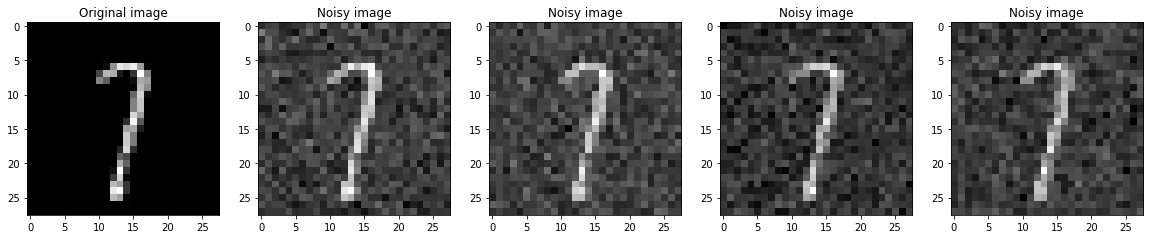

In [19]:
i = 523

X_adversarial = create_adversarial_examples(i=i, n_samples=1000, m=0, std=0.11, seed=5)
Y_adversarial = [yt2[i][0]]*1000

fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(20, 7)) 

ax[0].imshow(xt2[i,:].reshape(28,28).reshape(28,28), "gray")
ax[0].set_title("Original image")

for i in range(1,5):
    ax[i].imshow(X_adversarial[i,:].reshape(28,28), "gray")
    ax[i].set_title("Noisy image")

plt.show()

The original image is still easily recognizable throught the noisy images, yet the SVC is starting to misclassify some of these noisy samples: the accuracy is not equal to 1 anymore:

In [20]:
svc.score(X_adversarial, Y_adversarial)

0.999

Hence, we managed to break the predictions of the model: since the accuracy equals $99.9\%$ it misclassified 1 noisy image out of 1000 images, which is still a decent performance.

In fact, we can't conclude whether the model is robust based on a single sample. Indeed, maybe the original image was an easy one to classify so that the model would be less sensitive to noises; maybe that on the other hand, the original image was a difficult one (even if the at the end, the model classified it correctly) and therefore, just a small random noise would be enough to foil the model. 

As a consequence, we need to look at several datasets. Below, we created many adversarial datasets that we gathered according to the classes of the original images (cf 3 lines of plot) and the level of noise (cf 3 columns of plot).
We keep track of the accuracies of the model on each dataset.

In [21]:
# Challenge the model on 100 adversdarial datasets produced by 1 digit images

acc1_std01 = []
acc1_std015 = []
acc1_std02 = []

for i in range(100):
    X_adversarial01 = create_adversarial_examples(i=i, n_samples=1000, m=0, std=0.1, seed=5)
    X_adversarial015 = create_adversarial_examples(i=i, n_samples=1000, m=0, std=0.15, seed=5)
    X_adversarial02 = create_adversarial_examples(i=i, n_samples=1000, m=0, std=0.2, seed=5)
    
    Y_adversarial = [yt2[i][0]]*1000
    
    score01 = svc.score(X_adversarial01, Y_adversarial)
    score015 = svc.score(X_adversarial015, Y_adversarial)
    score02 = svc.score(X_adversarial02, Y_adversarial)
    
    acc1_std01.append(score01)
    acc1_std015.append(score015)
    acc1_std02.append(score02)
    

In [22]:
# Challenge the model on 100 adversdarial datasets produced by 7 digit images

acc7_std01 = []
acc7_std015 = []
acc7_std02 = []

# Be careful about the misclassified 7 digit samples 
indexes7 = [k for k in range(500,550)]
indexes7.extend([k for k in range(780,830)])

for i in indexes7:
    X_adversarial01 = create_adversarial_examples(i=i, n_samples=1000, m=0, std=0.1, seed=5)
    X_adversarial015 = create_adversarial_examples(i=i, n_samples=1000, m=0, std=0.15, seed=5)
    X_adversarial02 = create_adversarial_examples(i=i, n_samples=1000, m=0, std=0.2, seed=5)
    
    Y_adversarial = [yt2[i][0]]*1000
    
    score01 = svc.score(X_adversarial01, Y_adversarial)
    score015 = svc.score(X_adversarial015, Y_adversarial)
    score02 = svc.score(X_adversarial02, Y_adversarial)
    
    acc7_std01.append(score01)
    acc7_std015.append(score015)
    acc7_std02.append(score02)


In [23]:
# Challenge the model on 100 adversdarial datasets produced by 8 digit images

acc8_std01 = []
acc8_std015 = []
acc8_std02 = []

for i in range(1200,1300):
    X_adversarial01 = create_adversarial_examples(i=i, n_samples=1000, m=0, std=0.1, seed=5)
    X_adversarial015 = create_adversarial_examples(i=i, n_samples=1000, m=0, std=0.15, seed=5)
    X_adversarial02 = create_adversarial_examples(i=i, n_samples=1000, m=0, std=0.2, seed=5)
    
    Y_adversarial = [yt2[i][0]]*1000
    
    score01 = svc.score(X_adversarial01, Y_adversarial)
    score015 = svc.score(X_adversarial015, Y_adversarial)
    score02 = svc.score(X_adversarial02, Y_adversarial)
    
    acc8_std01.append(score01)
    acc8_std015.append(score015)
    acc8_std02.append(score02)

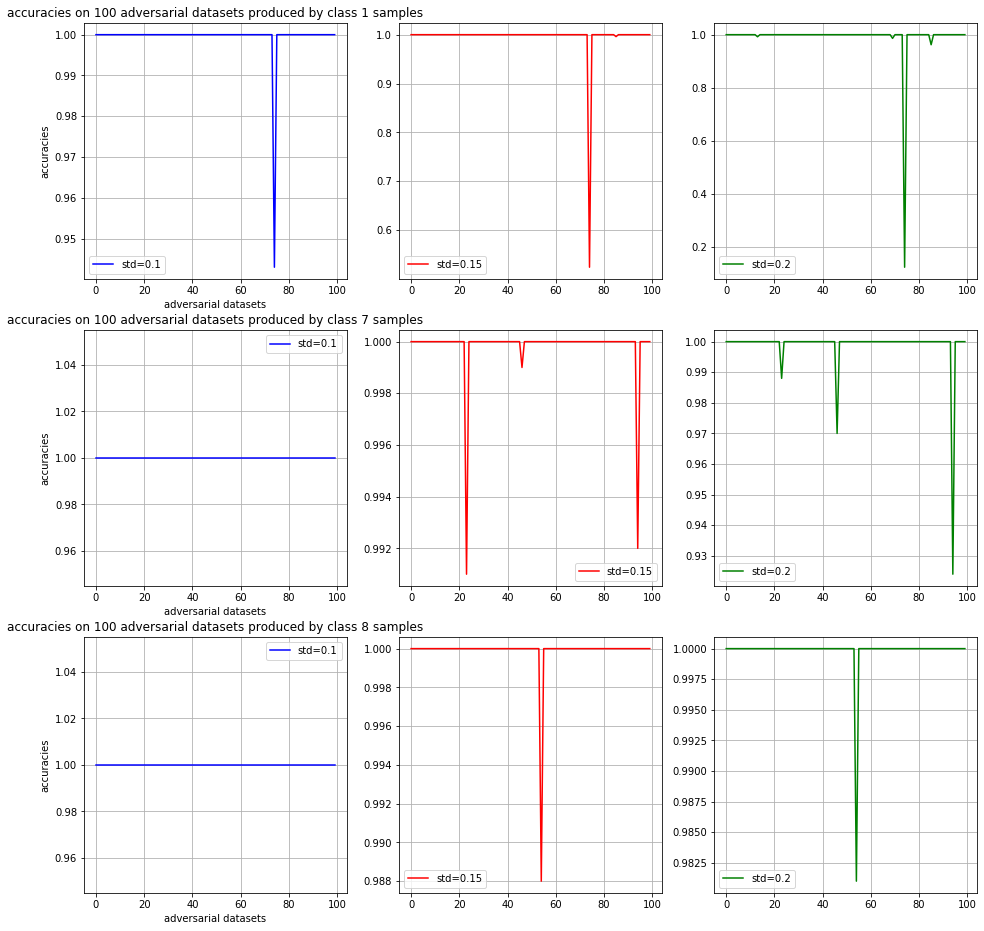

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=3, figsize=(16,16))

ax1[0].plot(acc1_std01, label="std=0.1", color="blue")
ax1[1].plot(acc1_std015, label="std=0.15", color="red")
ax1[2].plot(acc1_std02, label="std=0.2", color="green")

ax2[0].plot(acc7_std01, label="std=0.1", color="blue")
ax2[1].plot(acc7_std015, label="std=0.15", color="red")
ax2[2].plot(acc7_std02, label="std=0.2", color="green")

ax3[0].plot(acc8_std01, label="std=0.1", color="blue")
ax3[1].plot(acc8_std015, label="std=0.15", color="red")
ax3[2].plot(acc8_std02, label="std=0.2", color="green")

for i,ax in enumerate((ax1, ax2, ax3)):
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[0].set_xlabel("adversarial datasets")
    ax[0].set_ylabel("accuracies")
    ax[0].set_title("accuracies on 100 adversarial datasets produced by class {} samples".format(digits[i]))

plt.show()

According to sample of datasets collected above:

- the model is robust to small noises ($\textit{std}=0.1$) applied to 7 and 8 digit images since the accuracies are always 1. For class 1, it made some mistakes on a single dataset as we can notice there is an accuracy below $95\%$. This is no big deal, the model is still very accurate on almost every adversarial dataset.


- when we increase the level of noises ($\textit{std}=0.15$), the model starts making more errors, especially on the datasets generated by 7 digit images (it failed to have a perfect score on 3 datasets among a hundred). The model still fails on the same dataset for class 1, but the number of misclassifications on that dataset is higher since the accuracy is now under $0.6$. 


- when we increase the noises even more ($\textit{std}=0.2$), the datasets corresponding to class 8 are not impacted (there is still only one dataset on which the model doesn't reach an accuracy of 1). Given the scaling of the y-axis, the model did really poorly on a dataset from class 1: the accuracy on this dataset is lower than $20\%$. It also failed on other dataset produced by 1 digit samples, but the accuracies are still really close to 1. On the datasets produced by 7 digit images, the model also fails on three datasets, and since the accuracies are lower than $99\%$, it does more than 10 misclassifications among 1000 adversarial images on each of these dataset.

I didn't increased the level of random noises more than that since we need to ensure the initial images are still recognizable through the adversarial images (which is the case for the tested values).

In conclusion, the SVC model seems pretty robust in general: for the highest level of noise tested ($\textit{std}=0.2$), it reached an accuracy of 1 on 292 adversarial datasets among a total of 300. It is still to be verified, but it looks like it is more sensitive to noises added on 7 digit images, which would not be surprinsing if it was the case: the model initially already had more trouble classifying the "7"s than the "1" and "8"s.  

### Personnal discussion:

- I set $\textit{scoring}=$"accuracy" in the grid search CV because the accuracy was the studied metric during the first part of the notebook, but if it was up to me, I would have chosen $\textit{scoring}=$"roc_auc" as we saw later that it was a more relevant metric in this context.


- This practical session was the occasion for me to enhance my knowledge about precisions, recalls and AUC adapted to multiclass classifications. I have mainly used them for binary classification so far, and I especially appreciated learning about the One vs One and One versus Rest approaches.


- I wonder how to deal with images of different shapes: in this dataset, all the images are 28x28, but if it wasn't the case, how should I transform the images so as to get a common dimension without deforming some of them too much ? 


- Also, what if the images are in RGB system ? Then we would have to deal with (28x28x3) images, so flattening them as we did in this practical session would produce 3 times longer vectors. I can imagine that standard models would rapidly overfit due to the high dimensionnality. 